# Environmental Sound Classification
In this project, we build an audio classification model inspired by the Teachable Machine approach to recognize various environmental sounds such as rain, thunder, footsteps, or traffic.

This notebook demonstrates how to:

🎙️ Collect and preprocess environmental audio samples

🧠 Train a sound classification model using machine learning

🎧 Make real-time predictions on new audio clips

🔄 Optionally export the model for use in web or mobile apps

In [1]:
# Cell 1: Import necessary libraries for audio classification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

## Audio Feature Extraction
In this section, we define functions to convert raw audio files into Mel Spectrograms — visual, time-frequency representations of sound.
These spectrograms act as the input features for our neural network, much like how Teachable Machine handles audio classification.

🔍 Why Mel Spectrograms?
They capture both frequency and temporal characteristics of audio

Easily processed by CNN-based models like image data

Help the model distinguish between different environmental sounds

In [2]:
# Cell 3: Define audio processing functions
def extract_features(file_path, duration=2.5, sr=22050):
    """Extract Mel Spectrogram features from an audio file"""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Generate Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )

        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

def visualize_audio_features(file_path, title="Mel Spectrogram"):
    """Visualize the audio features extracted from an audio file"""
    features = extract_features(file_path)

    if features is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            features,
            x_axis='time',
            y_axis='mel',
            sr=22050,
            hop_length=512
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

## Dataset Preparation
For this project, we'll use Google's Speech Commands dataset, a widely-used benchmark in audio classification.
It includes thousands of short utterances of words like "yes", "no", "up", "down", and more—making it ideal for training a voice command recognition system.

📦 What this dataset offers:
Clean, labeled audio clips (~1-second each)

A diverse set of common voice commands

Consistent format, perfect for Mel spectrogram extraction and deep learning

In [3]:
# Cell 5: Use Google's Speech Commands dataset (which is more accessible)
!wget -q http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir -p speech_commands
!tar -xzf speech_commands_v0.01.tar.gz -C speech_commands

# Explore the dataset
import glob

# Get list of audio classes (directories)
class_dirs = [d for d in glob.glob('speech_commands/*') if os.path.isdir(d)]
class_names = [os.path.basename(d) for d in class_dirs]

# Count files per class
class_counts = {}
for class_dir in class_dirs:
    class_name = os.path.basename(class_dir)
    class_counts[class_name] = len(glob.glob(f"{class_dir}/*.wav"))

# Print dataset info
print(f"Total classes: {len(class_names)}")
print(f"Classes: {', '.join(sorted(class_names)[:10])}...")  # Show first 10
print("\nSamples per class:")
for class_name, count in sorted(class_counts.items())[:10]:  # Show first 10
    print(f"{class_name}: {count}")

Total classes: 31
Classes: _background_noise_, bed, bird, cat, dog, down, eight, five, four, go...

Samples per class:
_background_noise_: 6
bed: 1713
bird: 1731
cat: 1733
dog: 1746
down: 2359
eight: 2352
five: 2357
four: 2372
go: 2372


## Data Processing
To prepare our audio data for model training, we'll convert each clip into a fixed-size Mel spectrogram.
This ensures consistent input dimensions across all samples, which is essential for training a neural network.

🔄 Key Steps:
Resample audio to a common sampling rate

Trim or pad audio clips to a fixed duration (e.g., 1 second)

Convert audio waveforms to Mel spectrograms

Normalize and reshape for model compatibility

In [4]:
# Cell 7: Prepare the dataset with fixed-size features
# Select a subset of classes to use (for faster training)
selected_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go']

# Fixed size for all spectrograms
def extract_fixed_features(file_path, duration=1.0, sr=22050, n_mels=128, time_steps=87):
    """Extract Mel Spectrogram features with fixed dimensions"""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Pad if too short
        if len(y) < sr * duration:
            y = np.pad(y, (0, int(sr * duration) - len(y)), 'constant')

        # Generate Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=2048,
            hop_length=512,
            n_mels=n_mels
        )

        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        # Ensure fixed size - either crop or pad
        if log_mel_spectrogram.shape[1] > time_steps:
            log_mel_spectrogram = log_mel_spectrogram[:, :time_steps]
        elif log_mel_spectrogram.shape[1] < time_steps:
            padding = np.zeros((n_mels, time_steps - log_mel_spectrogram.shape[1]))
            log_mel_spectrogram = np.hstack((log_mel_spectrogram, padding))

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Modified function to process audio files with fixed dimensions
def prepare_dataset(classes, max_per_class=100):
    features = []
    labels = []

    for class_name in classes:
        print(f"Processing class: {class_name}")
        class_path = f"speech_commands/{class_name}"
        files = glob.glob(f"{class_path}/*.wav")[:max_per_class]

        for file_path in files:
            mel_spectrogram = extract_fixed_features(file_path)

            if mel_spectrogram is not None:
                features.append(mel_spectrogram)
                labels.append(classes.index(class_name))

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Reshape for CNN input: (samples, height, width, channels)
    features = features.reshape(features.shape[0], features.shape[1], features.shape[2], 1)

    return features, labels

# Prepare the dataset (with fewer samples for faster processing)
X, y = prepare_dataset(selected_classes, max_per_class=100)

Processing class: yes
Processing class: no
Processing class: up
Processing class: down
Processing class: left
Processing class: right
Processing class: stop
Processing class: go


## Model Architecture
We'll build a Convolutional Neural Network (CNN) specifically designed to process Mel spectrograms and classify them into voice command categories.

🏗️ Architecture Highlights:
📦 Convolutional layers to capture local time-frequency patterns in audio

🌀 Pooling layers to reduce dimensionality and retain key features

🧱 Dense layers for high-level reasoning and final classification

💡 Optimized for spectrogram inputs similar to how image models operate

In [5]:
# Cell 9: Build and train the CNN model for audio classification
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, len(selected_classes))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, len(selected_classes))

# Build the model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 85, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,223,752 (16.11 MB)

 Trainable params: 4,223,752 (16.11 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
We’ll now train our audio classification model using the prepared Mel spectrograms.
To ensure optimal performance and prevent overfitting, we’ll incorporate early stopping and save the best-performing model based on validation accuracy.

🔁 Training Strategy:
✅ EarlyStopping to halt training when validation accuracy stops improving

💾 ModelCheckpoint to save the best model weights

📊 Monitor both training and validation metrics to evaluate learning progress

In [6]:
# Cell 11: Train the model
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_audio_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train_one_hot,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.1185 - loss: 9.9570 

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 730ms/step - accuracy: 0.1198 - loss: 9.7352 - val_accuracy: 0.2313 - val_loss: 2.0424
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.2560 - loss: 1.9720

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 637ms/step - accuracy: 0.2559 - loss: 1.9706 - val_accuracy: 0.3500 - val_loss: 1.8197
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3623 - loss: 1.7459

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 640ms/step - accuracy: 0.3637 - loss: 1.7441 - val_accuracy: 0.4500 - val_loss: 1.6070
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.4819 - loss: 1.4686

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 606ms/step - accuracy: 0.4817 - loss: 1.4681 - val_accuracy: 0.5688 - val_loss: 1.3904
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 599ms/step - accuracy: 0.5422 - loss: 1.2934 - val_accuracy: 0.5688 - val_loss: 1.2923
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6450 - loss: 0.9884

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 648ms/step - accuracy: 0.6456 - loss: 0.9873 - val_accuracy: 0.5750 - val_loss: 1.1731
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7512 - loss: 0.7497

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 657ms/step - accuracy: 0.7501 - loss: 0.7507 - val_accuracy: 0.5938 - val_loss: 1.1303
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step - accuracy: 0.7838 - loss: 0.6746 - val_accuracy: 0.5750 - val_loss: 1.2483
Epoch 9/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7962 - loss: 0.5502

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.7958 - loss: 0.5514 - val_accuracy: 0.6625 - val_loss: 1.0925
Epoch 10/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8330 - loss: 0.4395

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 650ms/step - accuracy: 0.8333 - loss: 0.4381 - val_accuracy: 0.6687 - val_loss: 1.2127
Epoch 11/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8498 - loss: 0.3998

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 649ms/step - accuracy: 0.8506 - loss: 0.3989 - val_accuracy: 0.6750 - val_loss: 1.1957
Epoch 12/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.8959 - loss: 0.3017 - val_accuracy: 0.6562 - val_loss: 1.3970
Epoch 13/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 609ms/step - accuracy: 0.9164 - loss: 0.2595 - val_accuracy: 0.6500 - val_loss: 1.2949
Epoch 14/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - accuracy: 0.9199 - loss: 0.2161 - val_accuracy: 0.6438 - val_loss: 1.4056
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6718 - loss: 1.0188
Test accuracy: 0.6625


## Evaluation
After training, we'll evaluate our model’s performance using both visual metrics and classification analysis.

📈 What We'll Do:
Plot the training and validation accuracy/loss curves to understand the model's learning behavior

Generate a confusion matrix to visualize how well the model distinguishes between different audio classes

Identify common misclassifications and potential areas for improvement

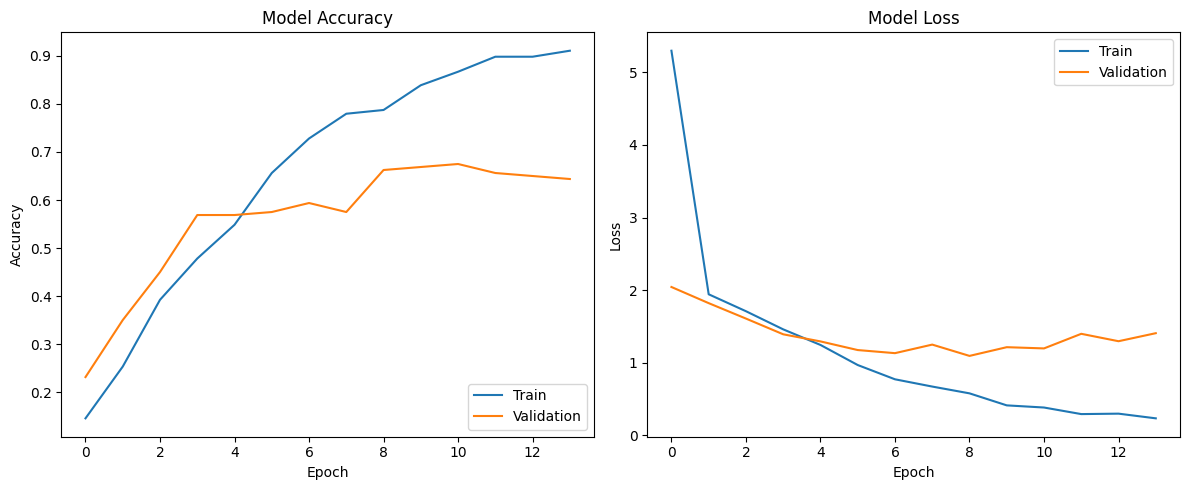

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


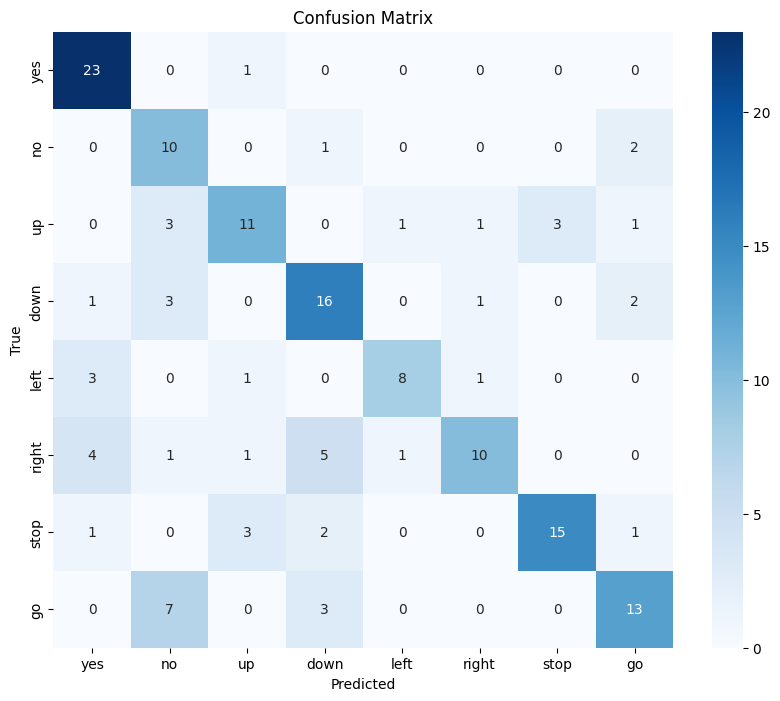

In [7]:
# Cell 13: Visualize training results
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Create a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_classes,
            yticklabels=selected_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Testing the Model
In this final step, we’ll test our trained model using new, unseen audio samples to evaluate its real-world performance.

🎯 Goals:
Predict voice command labels for fresh audio inputs

Verify the model’s recognition accuracy on out-of-training samples

Ensure consistent performance across different classes and acoustic variations


Testing: speech_commands/yes/439c84f4_nohash_0.wav (True class: yes)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


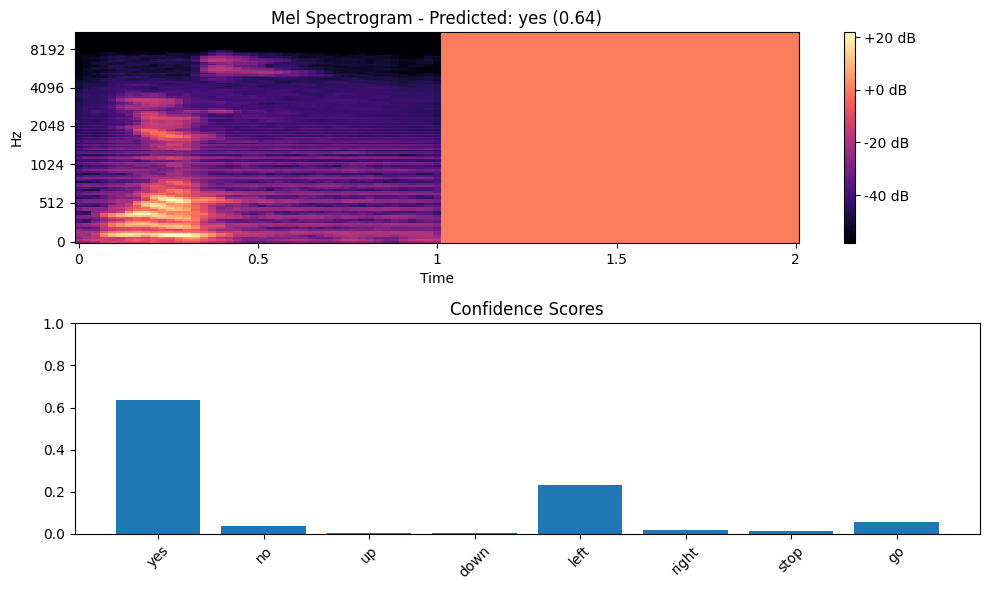

Predicted: yes with confidence 0.6358
Correct: ✓

Testing: speech_commands/no/bdee441c_nohash_5.wav (True class: no)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


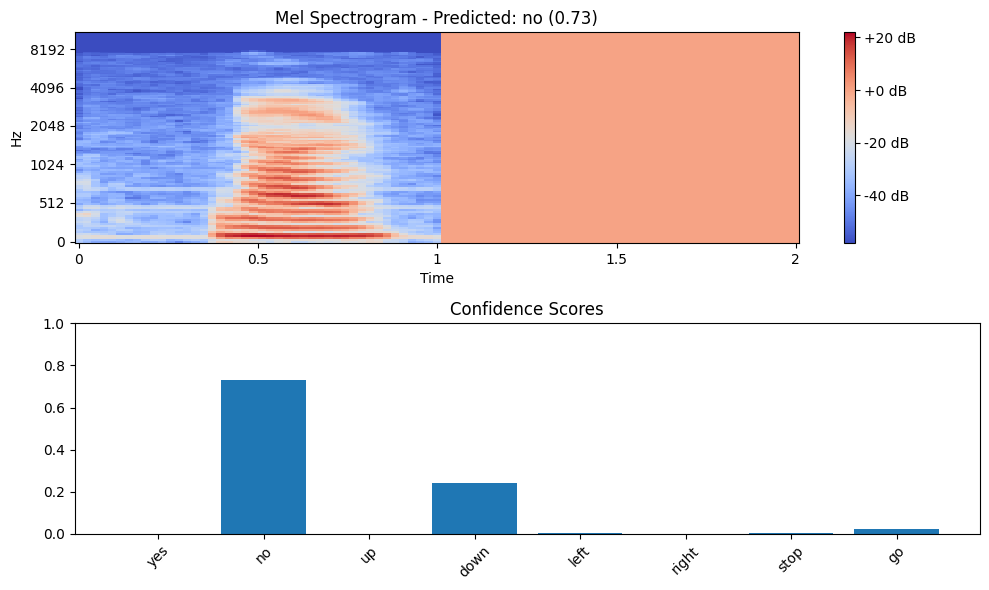

Predicted: no with confidence 0.7292
Correct: ✓

Testing: speech_commands/up/b1de039c_nohash_0.wav (True class: up)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


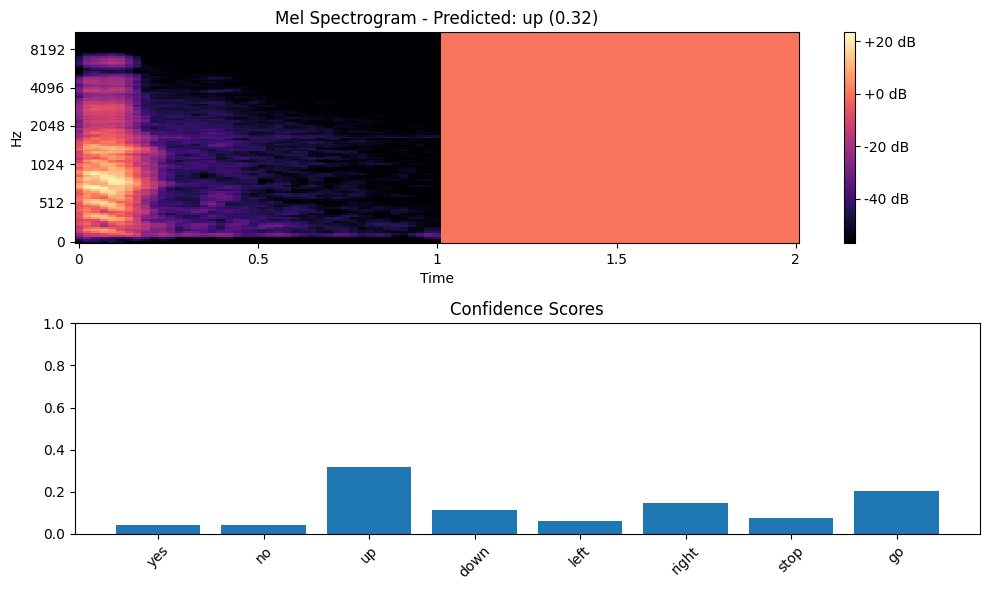

Predicted: up with confidence 0.3154
Correct: ✓


In [8]:
# Cell 15: Test the model with new audio samples
def predict_audio_class(file_path, model, class_names):
    # Extract features
    features = extract_fixed_features(file_path)

    if features is not None:
        # Reshape for model input
        features = features.reshape(1, features.shape[0], features.shape[1], 1)

        # Make prediction
        predictions = model.predict(features)[0]
        predicted_class_index = np.argmax(predictions)
        predicted_class = class_names[predicted_class_index]
        confidence = predictions[predicted_class_index]

        # Display the spectrogram
        plt.figure(figsize=(10, 6))

        # Plot spectrogram
        plt.subplot(2, 1, 1)
        librosa.display.specshow(
            features[0, :, :, 0],
            x_axis='time',
            y_axis='mel',
            sr=22050,
            hop_length=512
        )
        plt.title(f"Mel Spectrogram - Predicted: {predicted_class} ({confidence:.2f})")
        plt.colorbar(format='%+2.0f dB')

        # Plot confidence scores
        plt.subplot(2, 1, 2)
        plt.bar(class_names, predictions)
        plt.ylim(0, 1)
        plt.title('Confidence Scores')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return predicted_class, confidence, predictions

    return None, None, None

# Test with sample audio files
test_files = []
for class_name in selected_classes:
    # Get one file from each class
    file_path = glob.glob(f"speech_commands/{class_name}/*.wav")[0]
    test_files.append((file_path, class_name))

# Test a few samples
for file_path, true_class in test_files[:3]:  # Test first 3 samples
    print(f"\nTesting: {file_path} (True class: {true_class})")
    predicted_class, confidence, _ = predict_audio_class(file_path, model, selected_classes)

    if predicted_class is not None:
        print(f"Predicted: {predicted_class} with confidence {confidence:.4f}")
        print(f"Correct: {'✓' if predicted_class == true_class else '✗'}")

##  Model Export
To make our model deployable across various platforms, we'll export it in multiple formats, similar to how Teachable Machine provides flexible export options.

📦 Export Targets:
✅ .h5 or .keras format for continued training or use in Keras/TensorFlow workflows

📱 TensorFlow Lite (.tflite) format for deployment on mobile and edge devices

🌐 (Optional) TensorFlow.js format for running in web applications

In [9]:
# Cell 17: Export the model for deployment
# Install tensorflowjs if not available
!pip install -q tensorflowjs

# Save the model in different formats
# 1. Keras H5 format
model.save('audio_classifier_model.h5')

# 2. TensorFlow.js format
import tensorflowjs as tfjs
!mkdir -p tfjs_audio_model
tfjs.converters.save_keras_model(model, 'tfjs_audio_model')

# 3. Save class names
import json
with open('tfjs_audio_model/class_names.json', 'w') as f:
    json.dump(selected_classes, f)

print("Model exported in the following formats:")
print("1. Keras H5: audio_classifier_model.h5")
print("2. TensorFlow.js: tfjs_audio_model/")
print("3. Class names: tfjs_audio_model/class_names.json")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
Model exported in the following formats:
1. Keras H5: audio_classifier_model.h5
2. TensorFlow.js: tfjs_audio_model/
3. Class names: tfjs_audio_model/class_names.json


In [10]:
import os
import shutil
import zipfile
from google.colab import files

# Path to the folder you want to download
folder_path = 'tfjs_audio_model'

# Check if the folder exists
if not os.path.exists(folder_path):
    print(f"Error: The folder '{folder_path}' does not exist.")
else:
    # Create a zip file of the folder
    zip_filename = f"{folder_path}.zip"

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through all files in the directory
        for root, dirs, filenames in os.walk(folder_path):
            for filename in filenames:
                # Create the full filepath
                file_path = os.path.join(root, filename)
                # Add file to the zip file
                # The arcname parameter specifies the path in the zip file
                zipf.write(file_path, arcname=os.path.relpath(file_path, os.path.dirname(folder_path)))

    # Download the zip file
    files.download(zip_filename)
    print(f"Downloaded '{folder_path}' as '{zip_filename}'.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded 'tfjs_audio_model' as 'tfjs_audio_model.zip'.
